# Lab 9: Generative Models

## A: [*Bayesian Linear Regression* ](#partA); B: [*Variational Autoencoder*](#partB)

[**Haiping Lu**](http://staffwww.dcs.shef.ac.uk/people/H.Lu/) -  [COM4509/6509 MLAI2021](https://github.com/maalvarezl/MLAI) @ The University of Sheffield

**Accompanying lectures**: [YouTube video lectures recorded in Year 2020/21.](https://www.youtube.com/watch?v=c7qt56HH_Wg&list=PLuRoUKdWifzzFL5Am_xk-NDwewFwm1-BM)

**Sources**: Part A is based on the [Bayesian regression with linear basis function models](https://github.com/krasserm/bayesian-machine-learning/blob/dev/bayesian-linear-regression/bayesian_linear_regression.ipynb) notebook by [Martin Krasser](https://github.com/krasserm). Part B is based on Lab 5 of my [SimplyDeep](https://github.com/haipinglu/SimplyDeep/) notebooks, with sources from Jaan Altosaar's [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/), Nitarshan Rajkumar's [Variational Autoencoders](https://github.com/nitarshan/variational-autoencoder/blob/master/Variational%20Autoencoder%20Tutorial.ipynb) notebook, Paul Guerrero's [Variational Autoencoders](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb) notebook, and PyTorch's [Variational Autoencoder code](https://github.com/pytorch/examples/blob/master/vae/main.py).

There are *three* questions in this notebook.

**Suggested reading**: 
* [Bayesian linear regression on Wiki](https://en.wikipedia.org/wiki/Bayesian_linear_regression)
* Bayesian linear regression (Section 3.3) in the [PRML book](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)
* [Variational Bayesian methods on Wiki](https://en.wikipedia.org/wiki/Variational_Bayesian_methods)
* [Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf)
* [Variational autoencoders notes](https://deepgenerativemodels.github.io/notes/vae/)
* [**Troubleshooting Deep Neural Networks - Josh Tobin**](http://josh-tobin.com/assets/pdf/troubleshooting-deep-neural-networks-01-19.pdf)

# <a id='partA'></a>A: Bayesian Linear Regression

## Why

[**Generative models**](https://en.wikipedia.org/wiki/Generative_model) can estimate the probability of the instance, and also the probability of a class label. One of their important applications is [uncertainty quantification](https://en.wikipedia.org/wiki/Uncertainty_quantification). 

We will start from the generative version of linear regression, our most basic machine learning model. The classic generative formulation of linear regression is called **Bayesian linear regression** or simply **Bayesian regression**.  

## A1. Recap of linear basis function models

*Note that the notations could be different from previous notations.*

Linear regression models share the property of being linear in their parameters but not necessarily in their input variables. Using non-linear basis functions of input variables, linear models are able model arbitrary non-linearities from input variables to targets. Polynomial regression is such an example and will be demonstrated later. A linear regression model $y(\mathbf{x}, \mathbf{w})$ can therefore be defined more generally as

$$
y(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j=1}^{M-1}{w_j \phi_j(\mathbf{x})} = \sum_{j=0}^{M-1}{w_j \phi_j(\mathbf{x})} = \mathbf{w}^T \boldsymbol\phi(\mathbf{x}) \tag{1}
$$

where $\phi_j$ are basis functions and $M$ is the total number of parameters $w_j$ including the bias term $w_0$. Here, we use the convention $\phi_0(\mathbf{x}) = 1$. The simplest form of linear regression models are also linear functions of their input variables i.e. the set of basis functions in this case is the identity $\boldsymbol\phi(\mathbf{x}) = \mathbf{x}$. The target variable $t$ of an observation $\mathbf{x}$ is given by a deterministic function $y(\mathbf{x}, \mathbf{w})$ plus additive random noise $\epsilon$. 

$$
t = y(\mathbf{x}, \mathbf{w}) + \epsilon \tag{2}
$$

We make the assumption that the noise is normally distributed i.e. follows a Gaussian distribution with zero mean and precision (= inverse variance) $\beta$. The corresponding probabilistic model i.e. the conditional distribution of $t$ given $\mathbf{x}$ can therefore be written as

$$
p(t \lvert \mathbf{x}, \mathbf{w}, \beta) = 
\mathcal{N}(t \lvert y(\mathbf{x}, \mathbf{w}), \beta^{-1}) =
\sqrt{\beta \over {2 \pi}} \exp\left(-{\beta \over 2} (t - y(\mathbf{x}, \mathbf{w}))^2 \right) \tag{3}
$$

where the mean of this distribution is the regression function $y(\mathbf{x}, \mathbf{w})$. 

### Likelihood function

For fitting the model and for inference of model parameters we use a training set of $N$ independent and identically distributed (i.i.d.) observations $\mathbf{x}_1,\ldots,\mathbf{x}_N$ and their corresponding targets $t_1,\ldots,t_N$. After combining column vectors $\mathbf{x}_i$ into matrix $\mathbf{X}$, where $\mathbf{X}_{i,:} = \mathbf{x}_i^T$, and scalar targets $t_i$ into column vector $\mathbf{t}$ the joint conditional probability of targets $\mathbf{t}$ given $\mathbf{X}$ can be formulated as

$$
p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) = 
\prod_{i=1}^{N}{\mathcal{N}(t_i \lvert \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i), \beta^{-1})} \tag{4}
$$

This is a function of parameters $\mathbf{w}$ and $\beta$ and is called the *likelihood function*. For better readability, it will be written as $p(\mathbf{t} \lvert \mathbf{w}, \beta)$ instead of $p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta)$ from now on. The log of the likelihood function can be written as 

$$
\log p(\mathbf{t} \lvert \mathbf{w}, \beta) = 
{N \over 2} \log \beta - 
{N \over 2} \log {2 \pi} - 
\beta E_D(\mathbf{w}) \tag{5}
$$

where $E_D(\mathbf{w})$ is the sum-of-squares error function coming from the exponent of the likelihood function.

$$
E_D(\mathbf{w}) = 
{1 \over 2} \sum_{i=1}^{N}(t_i - \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i))^2 = 
{1 \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{w} \rVert^2 \tag{6}
$$

Matrix $\boldsymbol\Phi$ is called the *design matrix* and is defined as

$$
\boldsymbol\Phi = 
\begin{pmatrix}
\phi_0(\mathbf{x}_1) &  \phi_1(\mathbf{x}_1) & \cdots & \phi_{M-1}(\mathbf{x}_1) \\ 
\phi_0(\mathbf{x}_2) &  \phi_1(\mathbf{x}_2) & \cdots & \phi_{M-1}(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(\mathbf{x}_N) &  \phi_1(\mathbf{x}_N) & \cdots & \phi_{M-1}(\mathbf{x}_N)
\end{pmatrix} \tag{7}
$$

### Maximum likelihood

Maximizing the log likelihood (= minimizing the sum-of-squares error function) w.r.t. $\mathbf{w}$ gives the maximum likelihood estimate of parameters $\mathbf{w}$. Maximum likelihood estimation can lead to severe over-fitting if complex models (e.g. polynomial regression models of high order) are fit to datasets of limited size. A common approach to prevent over-fitting is to add a regularization term to the error function. As we will see shortly, this regularization term arises naturally when following a Bayesian approach (more precisely, when defining a prior distribution over parameters $\mathbf{w}$). 

## A2. Bayesian approach to linear regression

### Prior and posterior distribution

For a Bayesian treatment of linear regression we need a prior probability distribution over model parameters $\mathbf{w}$. For reasons of simplicity, we will use an isotropic Gaussian distribution over parameters $\mathbf{w}$ with zero mean:

$$
p(\mathbf{w} \lvert \alpha) = \mathcal{N}(\mathbf{w} \lvert \mathbf{0}, \alpha^{-1}\mathbf{I}) \tag{8}
$$

An isotropic Gaussian distribution has a diagonal covariance matrix where all diagonal elements have the same variance $\alpha^{-1}$ ($\alpha$ is the precision of the prior). A zero mean favors small(er) values of parameters $w_j$ a priori. The prior is [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior) to the likelihood $p(\mathbf{t} \lvert \mathbf{w}, \beta)$ meaning that the posterior distribution has the same functional form as the prior i.e. is also a Gaussian. In this special case, the posterior has an analytical solution with the following [sufficient statistics](https://en.wikipedia.org/wiki/Sufficient_statistic). 

$$
\begin{align*}
\mathbf{m}_N &= \beta \mathbf{S}_N \boldsymbol\Phi^T \mathbf{t}  \tag{9} \\
\mathbf{S}_N^{-1} &= \alpha\mathbf{I} + \beta \boldsymbol\Phi^T \boldsymbol\Phi  \tag{10}
\end{align*}
$$

$(9)$ is the mean vector of the posterior and $(10)$ the inverse covariance matrix (= precision matrix). Hence, the posterior distribution can be written as

$$
p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) = \mathcal{N}(\mathbf{w} \lvert \mathbf{m}_N, \mathbf{S}_N) \tag{11}
$$

For the moment, we assume that the values of $\alpha$ and $\beta$ are known. Since the posterior is proportional to the product of likelihood and prior, the log of the posterior distribution is proportional to the sum of the log likelihood and the log of the prior

$$
\log p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) = 
-\beta E_D(\mathbf{w}) - \alpha E_W(\mathbf{w}) + \mathrm{const.} \tag{12}
$$

where $E_D(\mathbf{w})$ is defined by $(6)$ and 

$$
E_W(\mathbf{w}) = {1 \over 2} \mathbf{w}^T \mathbf{w} \tag{13}
$$

Maximizing the log posterior w.r.t. $\mathbf{w}$ gives the [maximum-a-posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) estimate of $\mathbf{w}$. Maximizing the log posterior is equivalent to minimizing the sum-of-squares error function $E_D$ plus a quadratic regularization term $E_W$. This particular form regularization is known as *L2 regularization* or *weight decay* as it limits the magnitude of weights $w_j$. The contribution of the regularization term is determined by the ratio $\alpha / \beta$.

### Posterior predictive distribution

For making a prediction $t$ at a new location $\mathbf{x}$ we use the posterior predictive distribution which is defined as

$$
p(t \lvert \mathbf{x}, \mathbf{t}, \alpha, \beta) = 
\int{p(t \lvert \mathbf{x}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) d\mathbf{w}} \tag{14}
$$

The posterior predictive distribution includes uncertainty about parameters $\mathbf{w}$ into predictions by weighting the conditional distribution $p(t \lvert \mathbf{x}, \mathbf{w}, \beta)$ with the posterior probability of weights $p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta)$ over the entire weight parameter space. By using the predictive distribution we're not only getting the expected value of $t$ at a new location $\mathbf{x}$ but also the **uncertainty for that prediction**. In our special case, the posterior predictive distribution is a Gaussian distribution

$$
p(t \lvert \mathbf{x}, \mathbf{t}, \alpha, \beta) = 
\mathcal{N}(t \lvert \mathbf{m}_N^T \boldsymbol\phi(\mathbf{x}), \sigma_N^2(\mathbf{x})) \tag{15}
$$

where mean $\mathbf{m}_N^T \boldsymbol\phi(\mathbf{x})$ is the regression function after $N$ observations and $\sigma_N^2(\mathbf{x})$ is the corresponding predictive variance

$$
\sigma_N^2(\mathbf{x}) = {1 \over \beta} + \boldsymbol\phi(\mathbf{x})^T \mathbf{S}_N \boldsymbol\phi(\mathbf{x}) \tag{16}
$$

The first term in $(16)$ represents the inherent noise in the data and the second term covers the uncertainty about parameters $\mathbf{w}$. So far, we have assumed that the values of $\alpha$ and $\beta$ are known. In a fully Bayesian treatment, however, we should define priors over $\alpha$ and $\beta$ and use the corresponding posteriors to additionally include uncertainties about $\alpha$ and $\beta$ into predictions, which will not be covered here. 

## A3. Implementation of Bayesian regression

### Posterior and posterior predictive distribution

We start with the implementation of the posterior and posterior predictive distributions. Function `posterior` computes the mean and covariance matrix of the posterior distribution and function `posterior_predictive` computes the mean and the variances of the posterior predictive distribution. Here, readability of code and similarity to the mathematical definitions has higher priority than optimizations.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

Let's define some plotting functions for visualisation.

In [2]:
def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="k", s=20)

def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)

def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')

def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')

def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')

def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

### Example datasets

The datasets used in the following examples are based on $N$ scalar observations $x_{i = 1,\ldots,N}$ which are combined into a $N \times 1$ matrix $\mathbf{X}$. Target values $\mathbf{t}$ are generated from $\mathbf{X}$ with functions `f` and `g` which also generate random noise whose variance can be specified with the `noise_variance` parameter. We will use `f` for generating noisy samples from a straight line and `g` for generating noisy samples from a sinusoidal function.

In [3]:
f_w0 = -0.3
f_w1 =  0.5

def f(X, noise_variance):
    '''Linear function plus noise'''
    return f_w0 + f_w1 * X + noise(X.shape, noise_variance)

def g(X, noise_variance):
    '''Sinusoidial function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

### Basis functions

For straight line fitting, a model that is linear in its input variable $x$ is sufficient. Hence, we don't need to transform $x$ with a basis function which is equivalent to using an `identity_basis_function`. For fitting a linear model to a sinusoidal dataset we transform input $x$ with `gaussian_basis_function` and later with `polynomial_basis_function`. These non-linear basis functions are necessary to model the non-linear relationship between input $x$ and target $t$. The design matrix $\boldsymbol\Phi$ can be computed from observations $\mathbf{X}$ and a parametric basis function with function `expand`. This function also prepends a column vector $\mathbf{1}$ according to $\phi_0(x) = 1$.

In [4]:
def identity_basis_function(x):
    return x

def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)

def polynomial_basis_function(x, power):
    return x ** power

def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

### Straight line fitting

For straight line fitting, we use a linear regression model of the form $y(x, \mathbf{w}) = w_0 + w_1 x$ and do Bayesian inference for model parameters $\mathbf{w}$. Predictions are made with the posterior predictive distribution. Since this model has only two parameters, $w_0$ and $w_1$, we can visualize the posterior density in 2D which is done in the first column of the following output. Rows use an increasing number of training data from a training dataset.

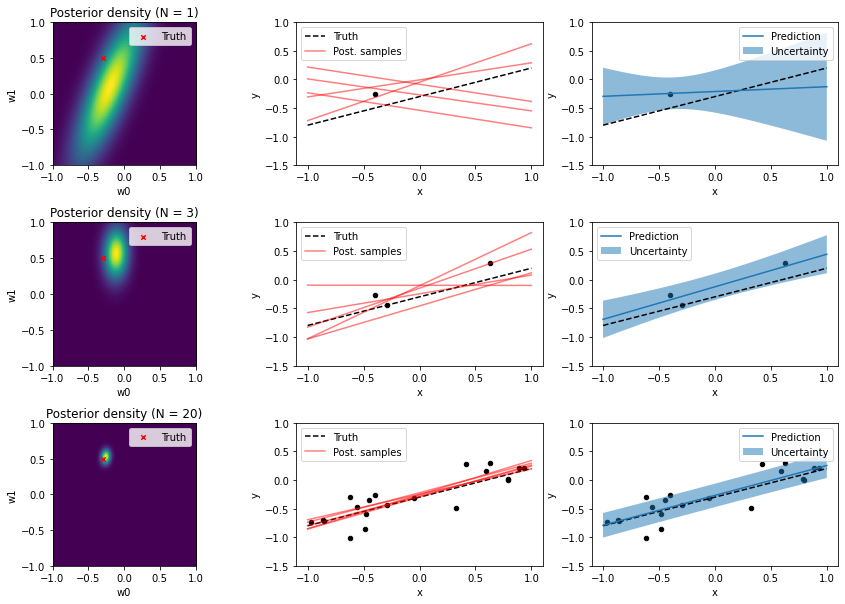

In [5]:
# Training dataset sizes
N_list = [1, 3, 20]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values
t = f(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = f(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, f_w0, f_w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()

In the second column, 5 random weight samples are drawn from the posterior and the corresponding regression lines are plotted in red color. The line resulting from the true parameters, `f_w0` and `f_w1` is plotted as dashed black line and the noisy training data as black dots. The third column shows the mean and the standard deviation of the posterior predictive distribution along with the true model and the training data.

It can be clearly seen how the posterior density in the first column gets more sharply peaked as the size of the dataset increases which corresponds to a decrease in the sample variance in the second column and to a decrease in prediction uncertainty as shown in the third column. Also note how prediction uncertainty is higher in regions of less observations. 

### Gaussian basis functions

The following example demonstrates how to fit a Gaussian basis function model to a noisy sinusoidal dataset. It uses 9 Gaussian basis functions with mean values equally distributed over $[0, 1]$ each having a standard deviation of $0.1$. Inference for parameters $\mathbf{w}$ is done in the same way as in the previous example except that we now infer values for 10 parameters (bias term $w_0$ and $w_1,\ldots,w_9$ for the 9 basis functions) instead of 2. We therefore cannot display the posterior density unless we selected 2 parameters at random.

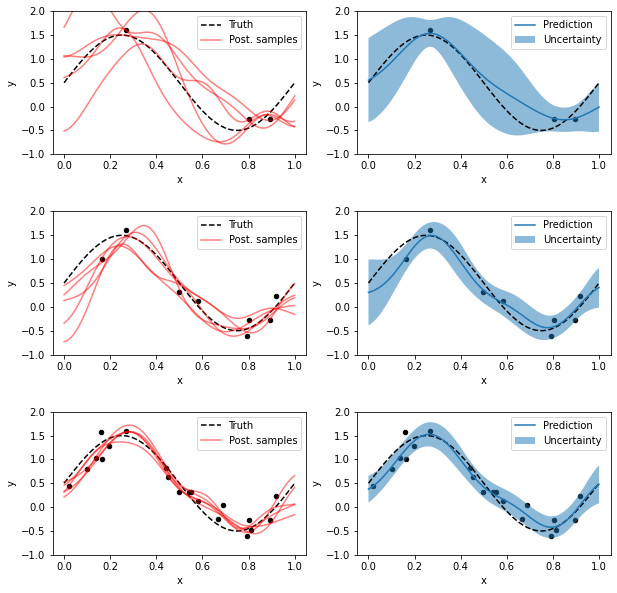

In [6]:
N_list = [3, 8, 20]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1)

# Training target values
t = g(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = g(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))

    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 2, i * 2 + 1)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.0, 2.0)
    plt.legend()
    
    plt.subplot(len(N_list), 2, i * 2 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.0, 2.0)
    plt.legend()

Again, as the size of the dataset increases the posterior sample variance and the prediction uncertainty decreases. Also, regions with less observations have higher prediction uncertainty.

# <a id='partB'></a>B: Variational Autoencoder for Deep Generative Learning

## Why

**Deep generative models** aim to combine the interpretable representations and quantified uncertainty offered by probabilistic models, with the flexibility and scalable learning of deep neural networks, from the [Deep Generative Models](http://stat.columbia.edu/~cunningham/teaching/GR8201/) course by [John P. Cunningham](http://stat.columbia.edu/~cunningham/). 

**Variational autoencoders** are such deep generative models. They let us design complex generative models of data, and fit them to large datasets. They yield state-of-the-art machine learning results in image generation and reinforcement learning and can generate [images of fictional celebrity faces](https://www.youtube.com/watch?v=XNZIN7Jh3Sg) and [high-resolution digital artwork](https://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/).

## B1. Neural network architecture

Like all autoencoders, the variational autoencoder is primarily used for unsupervised learning of hidden/latent representations. However, they are fundamentally different in that they approach the problem from a probabilistic perspective. They specify a joint distribution over the observed and latent variables, and approximate the intractable posterior conditional density over latent variables with [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods).

A variational autoencoder consists of an encoder, a decoder, and a loss function as a typical autoencoder: 

<img src="https://jaan.io/images/encoder-decoder.png"
     alt="Markdown Monster icon"
     style="height: 120px" />
     
* The **encoder** takes a datapoint $x$ as the input and encodes it to produce a hidden/latent representation $z$ as the output, with parameters $\theta$ (weights and biases). The encoder in a VAE can be written as a Gaussian probability density $q_\theta (z \mid x)$ to model a stochastic lower-dimensional space is stochastic. The encoder outputs parameters to $q_\theta (z \mid x)$ and we can sample from this distribution to get noisy values of the representations $z$. 
* The **decoder** $p_\phi(x\mid z)$ takes the representation $z$ as the input and outputs the parameters to the probability distribution of the data $p_\phi (x\mid z)$, with parameters $\phi$ (weights and biases). The reconstruction log-likelihood $\log p_\phi (x\mid z)$ tells us how effectively the decoder has learned to reconstruct (autoencode) an input image $x$ given its latent representation $z$.

* <p>The **loss function** is the negative log-likelihood with a regularizer. The loss function $l_i$ for a single datapoint $x_i$ is:
\begin{equation}
\:\\
l_i(\theta, \phi) = - \mathbb{E}_{z\sim q_\theta(z\mid x_i)}[\log p_\phi(x_i\mid z)] + \mathbb{KL}(q_\theta(z\mid x_i) \mid\mid p(z))\\
\tag{1}\end{equation}
Datapoints are assumed to be independent so the total loss is $\sum_{i=1}^N l_i$ for $N$ total datapoints. The first term aims for reconstruction and is defined as the expected negative log-likelihood of the $i$-th datapoint, with the expectation taken w.r.t. to the encoder’s distribution over the representations. The second term is a regularizer in the form of the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the encoder’s
distribution $q_\theta(z\mid x)$ (the approximation) and $p(z)$ (the ground truth), measuring their mismatch.
 
The variational autoencoder specifies $p$ as a standard Gaussian distribution with mean zero and variance one. If the encoder outputs representations $z$ having a distribution different from a standard Gaussian, there will be a penalty (proportional to the amount of difference) in the loss. The training of VAE uses gradient descent to optimize the loss with respect to the parameters of the encoder and decoder $\theta$ and $\phi$. 

**Example**: A $28\times 28$ handwritten digit image can be represented as $0$ or $1$ (black or white). We use a Bernoulli distribution to represent the probability distribution of a single pixel. The decoder receives the latent representation of a digit $z$ and outputs $784$ Bernoulli parameters, one for each of the $784$ pixels, from which we can **sample** or **generate** digits.

## B2. Probabilistic modelling in variational autoencoder 

*This section is **optional**. You may skip it safely if you are only interested in using VAE.*

From a probability model perspective, a variational autoencoder is a latent variable model that **generates** a datapoint $x$ from latent variables $z$ with a joint probability $p(x, z) = p(x \mid z) p(z)$. 
<img src="https://jaan.io/images/graphical-model-variational-autoencoder.png"
     alt="Markdown Monster icon"
     style="height: 100px" />
For each datapoint $i$, latent variable $z_i$ are first drawn from a prior distribution $p(z)$: $z_i \sim p(z)$. Then, a datapoint $x_i$ is drawn from the likelihood $p(x\mid z)$: $x_i \sim p(x\mid z)$. Recall that we have $p(x,z) = p(x\mid z)p(z)$. For a black and white digit image, the likelihood has a Bernoulli distribution.

With a Bayesian approach, the **inference** task is to learn good values of the latent variables given observed data in terms of the posterior

$$p(z \mid x) = \frac{p(x \mid z)p(z)}{p(x)}.$$

The denominator $p(x)$ is the marginal distribution of $x$ (the evidence): $p(x) = \int p(x \mid z) p(z) dz$. This integral requires exponential time to compute so we need to an approximation.  

**Variational inference** approximates the posterior with a family of distributions $q_\lambda(z \mid x)$ indexed by the variational parameter(s) $\lambda$, which are the mean and variance for Gaussian distributions: $\lambda = (\mu, \sigma^2))$. We can use the **Kullback-Leibler divergence** to measure how well the variational posterior $q(z \mid x)$ approximates the true posterior $p(z \mid x)$: 

$$\mathbb{KL}(q_\lambda(z \mid x) \mid \mid p(z \mid x)) = \mathbf{E}_q[\log q_\lambda(z \mid x)]- \mathbf{E}_q[\log p(x, z)] + \log p(x)$$

Optimizing the KL divergence above is intractable. However, if we define the **Evidence Lower BOund** (ELBO)

$$ELBO(\lambda) = \mathbf{E}_q[\log p(x, z)] - \mathbf{E}_q[\log q_\lambda(z \mid x)],$$

then we can combine this with the KL divergence and rewrite the evidence (marginal distribution) as</p>

$$\log p(x) = ELBO(\lambda) + \mathbb{KL}(q_\lambda(z \mid x) \mid \mid p(z \mid x))$$

By Jensen’s inequality, the KL divergence is always non-negative so minimizing this KL divergence is equivalent to maximizing the ELBO because $p(x)$ is fixed (though intractable). 


---
### Question 1

Why is $ELBO(\lambda)$ the lower bound for $\log p(x)$?

**Answer**: 

---

The KL divergence is always non-negative. Therefore from

$$\log p(x) - \mathbb{KL}(q_\lambda(z \mid x) \mid \mid p(z \mid x))= ELBO(\lambda) $$

We can obtain

$$\log p(x) \geqslant ELBO(\lambda) $$

---

The ELBO enables approximate posterior inference. Maximizing the ELBO is equivalent (but computationally tractable) to minimizing the KL divergence between the approximate and exact posteriors.

The variational autoencoder model further assumes that no datapoint shares its latent $z$ with another datapoint so that we can decompose the ELBO as a sum of the ELBOs for each single datapoint:

$$ELBO_i(\lambda) = \mathbb{E}_{q_\lambda(z\mid x_i)}[\log p(x_i\mid z)] - \mathbb{\mathbb{KL}}(q_\lambda(z\mid x_i) \mid\mid p(z)).$$

Now, we can use stochastic gradient descent with respect to the parameters $\lambda$ (which are shared across datapoints).

---
### Question 2

Verify that this definition for $ELBO_i(\lambda)$ is equivalent to our previous definition of the ELBO. 

*Hint: expand the log joint into the prior and likelihood terms and use the product rule for the logarithm.*

**Answer**: 

---

$$ELBO(\lambda) = \mathbf{E}_q[\log p(x, z)] - \mathbf{E}_q[\log q_\lambda(z \mid x)],$$

$$ = \mathbf{E}_q[\log p(z)p(x|z)] - \mathbf{E}_q[\log q_\lambda(z \mid x)],$$

$$ = \mathbf{E}_q[\log p(z)] + \mathbf{E}_q[\log p(x|z)] - \mathbf{E}_q[\log q_\lambda(z \mid x)],$$

$$ =  \mathbf{E}_q[\log p(x|z)] - (\mathbf{E}_q[\log q_\lambda(z \mid x)] - \mathbf{E}_q[\log p(z)]),$$

$$ =  \mathbf{E}_q[\log p(x|z)] - \mathbb{\mathbb{KL}}(q_\lambda(z\mid x_i) \mid\mid p(z)).$$

---

Next, we parametrize the approximate posterior $q_\theta (z \mid x, \lambda)$ with an **inference network** (encoder) that takes data $x$ in and outputs parameters $\lambda$, with learnable parameter $\theta$ (weights and biases). And we parameterize the likelihood $p(x \mid z)$ with a **generative network** (decoder) that takes latent variables in and outputs parameters to the data distribution $p_\phi(x \mid z)$, with learnable parameters $\phi$ (weights and biases). $\theta$ and $\phi$ can be learned by maximizing the ELBO using stochastic gradient descent with minibatch. We can write the ELBO and include the inference and generative network parameters as:</p>

$$ELBO_i(\theta, \phi) = \mathbb{E}_{q_\theta(z\mid x_i)}[\log p_\phi(x_i\mid z)] - \mathbb{KL}(q_\theta(z\mid x_i) \mid\mid p(z)).$$

Notice that this evidence lower bound is the negative of the loss function $l_i(\theta, \phi)$ defined in Equation (1): $ELBO_i(\theta, \phi) = -l_i(\theta, \phi)$. 

The probability model approach reveals that two terms in Equation (1) aim to minimize the KL divergence (mismatch) between the approximate posterior $q_\lambda(z \mid x)$ and (true) model posterior $p(z \mid x)$.

**Summary**: In this variational inference, we've defined a probability model $p$ of latent variables and data, as well as a variational family $q$ for the latent variables to approximate our posterior. Then the variational inference algorithm can learn the variational parameters through gradient *ascent* on the ELBO. 


## B3. Reparameterization trick

To implement the variational autoencoder, we need to take derivatives w.r.t. the parameters of a stochastic variable. If $z$  is drawn from a distribution $q_\theta (z \mid x)$, how to take derivatives of a function of $z$ with respect to $\theta$? The  sample $z$ is fixed, but intuitively its derivative should be nonzero.

For Gaussian distributions, we can reparametrize samples in a clever way so that the stochasticity is independent of the parameters, e.g. by making samples to deterministically depend on the parameters of the distribution. For example, in a Gaussian variable with mean $\mu$ and standard devation $\sigma$, we can sample from it as:</p>

$$z = \mu + \sigma \odot \epsilon,$$

<p>where $\epsilon \sim \mathcal{N}(0, 1)$. In this way, we have defined a function which depends on the parameters deterministically so that we can take derivatives of functions involving $z$, $f(z)$ w.r.t. to the parameters of its distribution $\mu$ and $\sigma$, which are output by an inference network with parameters $\theta$ that we optimize. 

<img src="https://jaan.io/images/reparametrization.png"
     alt="Markdown Monster icon"
     style="height: 120px" />

Through this trick, we can backpropagate w.r.t. $\theta$ through the objective (the ELBO) which is a function of samples of the latent variables $z$. 

## B4. Variational Autoencoder via PyTorch

Let us implement a VAE in PyTorch to learn a generative model for handwritten digit images from the  MNIST dataset. We use the following common setup: a multivariate Gaussian distribution for the conditional distribution $q_{\theta}(z | x)$  and a multivariate Bernoulli distribution for the conditional distribution $p_{\phi}(x | z)$, which reduces the reconstruction loss (the first term in Equation (1)) to the pixel-wise binary cross-entropy loss. See the [original VAE paper](https://arxiv.org/pdf/1312.6114.pdf) for details.

#### Set up and get ready to build a VAE
First, get ready by importing libraries.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from tqdm.notebook import tnrange

import torch
from torch.utils.data.dataloader import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.utils import make_grid 

torch.manual_seed(2020)
sns.set_style('dark')
%matplotlib inline

Set up the experiments, including data loaders. MNIST images are gray-level images with pixel values in [0,1], which will be treated as probabilities of being white (0 probability means black).

In [8]:
batch_size=128   # input batch size for training (default: 128)
num_epochs=10    # number of epochs to train (default: 10)')
num_visual=16    # For compare original and constructed digits
num_grid=20      # For visualising generated digits in grid
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if you have one
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

train_loader = DataLoader(datasets.MNIST('data', train=True, download=True, 
        transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(datasets.MNIST('data', train=False, 
        transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True, **kwargs)

#### Construct the VAE

Now construct the VAE model and do an inspection. We use fully connected layers here. 

In [9]:
class VAE(nn.Module):
    def __init__(self,latent_dim=20,hidden_dim=500):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # mean
        self.fc22 = nn.Linear(hidden_dim, latent_dim) #logvar
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

myVAE = VAE().to(device)
print(myVAE)

VAE(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc21): Linear(in_features=500, out_features=20, bias=True)
  (fc22): Linear(in_features=500, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=784, bias=True)
)


Define the loss function and choose the optimizer. 

In [10]:
optimizer = optim.Adam(myVAE.parameters(), lr=learning_rate)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (BCE + KLD) / recon_x.size(0) # normalize by batch size

#### Training, testing and visualisation

Let us train the model and plot the losses against batches.

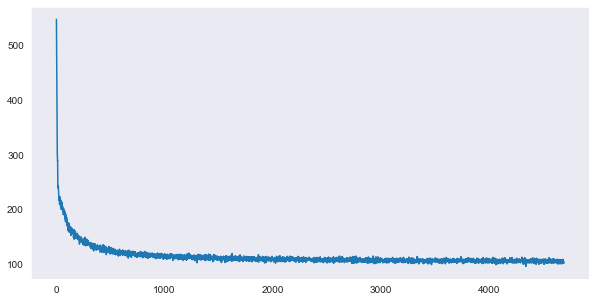

In [11]:
# Training
def train(model,optimizer,dataloader):
    model.train() # set to training mode
    losses = []
    for epoch in tnrange(num_epochs,desc='Epochs'):
        for data, _ in dataloader:        
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            losses.append(loss.item()) # train_loss += loss.item()
            optimizer.step()
    return losses

train_losses = train(myVAE,optimizer,train_loader)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()

Zoom in to the converging region and compute the moving average of losses to observe the trend.

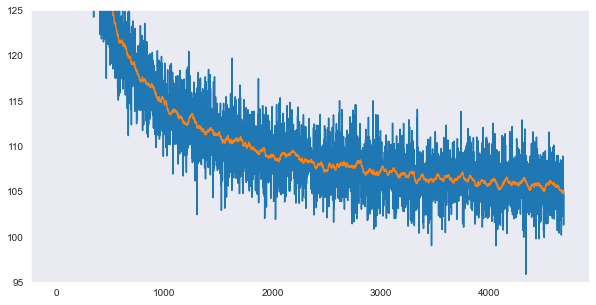

In [12]:
# Visualize moving average of losses
def visualize_losses_moving_average(losses,window=50,boundary='valid',ylim=(95,125)):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

visualize_losses_moving_average(train_losses)

Evaluate on the test dataset.

In [13]:
# Testing
def test(model,dataloader):
    model.eval() # set to evaluation mode
    test_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            loss = loss_function(recon_batch, data, mu, logvar).item()
            test_loss += loss*data.size(0)
    return test_loss/len(dataloader.dataset)

test_loss = test(myVAE, test_loader)
print(test_loss)    

105.83679247436524


Let us compare the images reconstructed from the learned latent representations with the original images. 

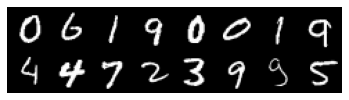

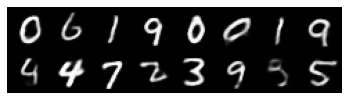

In [14]:
# Visualize VAE input and reconstruction
def visualize_mnist_vae(model,dataloader,num=num_visual):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
    
    with torch.no_grad(): 
        data,_ = iter(dataloader).next()
        data = data.to(device)
        data = data[0:num,:,:]        
        recon_batch,_,_ = model(data)
        recon_batch = recon_batch.data.view(num, 1, 28, 28)
        imshow(make_grid(data))
        imshow(make_grid(recon_batch))

visualize_mnist_vae(myVAE,test_loader)

#### 2D latent space studies
Let us set the latent dimension to 2 for easy visualisation. With this setting, the reconstruction is poorer than higher latent dimension.


155.4108153274536


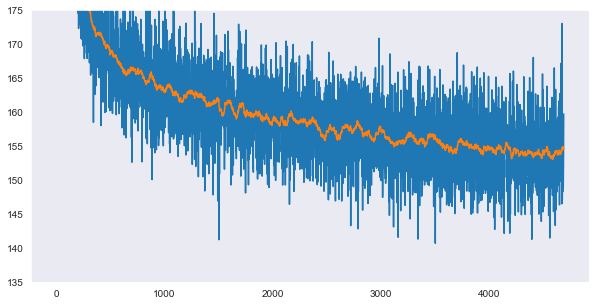

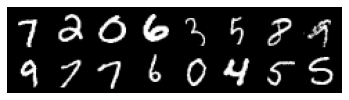

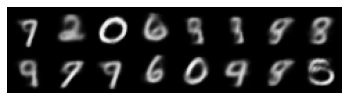

In [15]:
# Train, test and visualize reconstruction using a 2D latent space
myVAE2 = VAE(latent_dim=2)
optimizer2 = optim.Adam(myVAE2.parameters(), lr=learning_rate)

train2_losses = train(myVAE2,optimizer2,train_loader)
test2_loss = test(myVAE2,test_loader)

print(test2_loss)
visualize_losses_moving_average(train2_losses,ylim=(135,175))
visualize_mnist_vae(myVAE2,test_loader)

Let us visualise the latent representations in a 2D space with the ground truth class labels to observe the *clustering* effects: the latent representations for the different classes of digits are placed in different parts of the latent space in most cases, though with overlap.

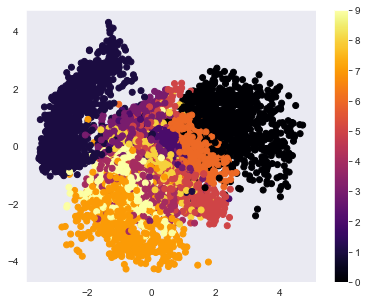

In [16]:
# Visualize test data encodings on the latent space
def visualize_encoder(model,dataloader):
    z_means_x, z_means_y, all_labels = [], [], []
    with torch.no_grad():
        for images,labels in iter(dataloader):
            z_means,_ = model.encode(images.view(-1,784)) # We visualise the mean
            z_means_x = np.append(z_means_x,z_means[:,0].data.numpy())
            z_means_y = np.append(z_means_y,z_means[:,1].data.numpy())
            all_labels = np.append(all_labels,labels.numpy())

    plt.figure(figsize=(6.5,5))
    plt.scatter(z_means_x,z_means_y,c=all_labels,cmap='inferno')
    plt.colorbar()
    plt.show()

visualize_encoder(myVAE2,test_loader)

#### VAE as a digit image generator

Using the learned generative VAE model, we can sample/generate new digit images via sampling their latent vectors at a regular grid from its prior distribution. We display them along the 2D latent space manifold. We can observe interesting patterns on the regularly spaced grid and interpret what each dimension of the latent space has captured. Although the generated digits are not perfect and have artefacts, they are usually better than for a non-variational Autoencoder.

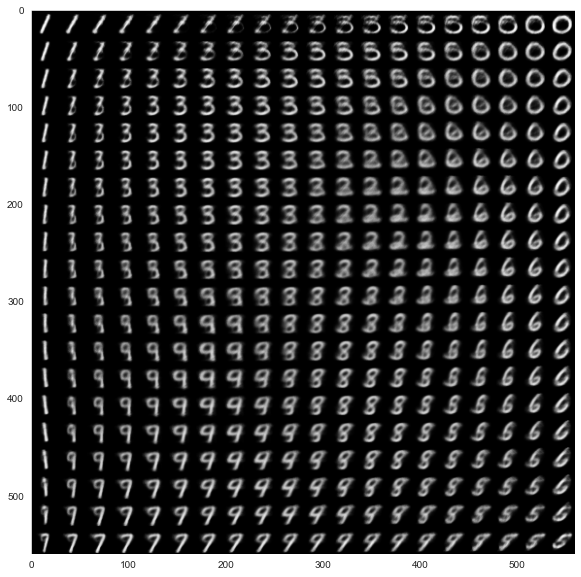

In [17]:
# Visualize digits generated from latent space grid
def visualize_decoder(model,num=num_grid,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))
    else:
        range_space = range_type
    with torch.no_grad():
        for i, x in enumerate(range_space):
            for j, y in enumerate(reversed(range_space)):
                z = torch.FloatTensor([[x,y]])
                image = model.decode(z).view(-1,1,28,28)
                image = image.data.numpy()
                image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid, cmap='gray')
    plt.show()

visualize_decoder(myVAE2)

---
### Question 3

* Make a *video* in any video or `gif` format to display the digits generated from the 2D latent space as frames and/or the progressive learning of the model (i.e. batch as the time axis).

**Answer**: 

---

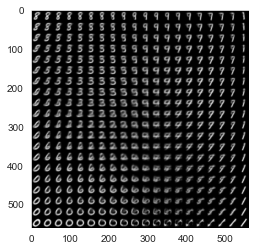

In [18]:
import matplotlib.animation as animation
%matplotlib inline
fig = plt.figure()
# Training
ims = []
def train_and_visualise(model,optimizer,dataloader):
    global ims
    image_grid = np.zeros([num_grid*28,num_grid*28])
    range_space = norm.ppf(np.linspace(0.01,0.99,num_grid))
    model.train() # set to training mode
    losses = []
    for epoch in tnrange(num_epochs,desc='Epochs'):
        for data, _ in dataloader:        
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            losses.append(loss.item()) # train_loss += loss.item()
            optimizer.step()
            
            #currently this produces a 4 minute long clip. Wrapping this in 'if((i%50) == 0)' will dramatically
            #reduce the training time, as well as the clip time
            with torch.no_grad():
                for i, x in enumerate(range_space):
                    for j, y in enumerate(reversed(range_space)):
                        z = torch.FloatTensor([[x,y]])
                        image = model.decode(z).view(-1,1,28,28)
                        image = image.data.numpy()
                        image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image
            ims.append([plt.imshow(image_grid, cmap='gray', animated=True)])
            image_grid = np.zeros([num_grid*28,num_grid*28])
    return losses

myVAE2 = VAE(latent_dim=2)
optimizer2 = optim.Adam(myVAE2.parameters(), lr=learning_rate)

train2_losses = train_and_visualise(myVAE2,optimizer2,train_loader)

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

ani.save('vis.mp4')

In [19]:
from IPython.display import Video

Video("vis.mp4")

---

## Additional ideas to explore
* Implement a convolutional VAE. An example is available [here](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb).
* Explore other VAEs following the [PyTorch-VAE](https://github.com/AntixK/PyTorch-VAE) repository to generate new faces from celebrities.
* Study [A Tutorial on Variational Autoencoders with a Concise Keras Implementation](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/) by Louis Tiao and implement the same in pytorch.
* Explore [PyroLab 1 - Bayesian Linear Regression for Generative Learning with Pyro](https://github.com/haipinglu/SimplyDeep/blob/master/PyroLab%201%20-%20Bayesian%20Linear%20Regression%20for%20Generative%20Learning%20with%20Pyro.ipynb)
* Explore [PyroLab 2 - Variational Autoencoder for Deep Generative Learning](https://github.com/haipinglu/SimplyDeep/blob/master/PyroLab%202%20-%20Variational%20Autoencoder%20for%20Deep%20Generative%20Learning.ipynb)
